In [1]:
# Code block 1

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Code block 2
# CUDA?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA Available?", cuda)

CUDA Available? True


In [4]:
# Code block 3

# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [5]:
# Code block 4

train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 149162841.22it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42046405.35it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35011144.39it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21261750.86it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
# Code block 5

batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

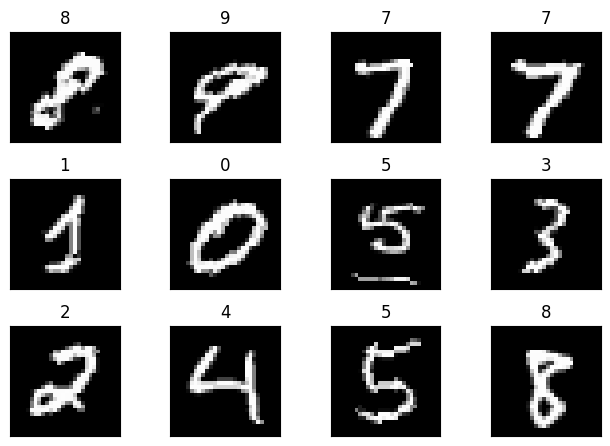

In [8]:
# Code block 6

import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [13]:
# Code block 7

class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) # 28>26 | 1>3 | 1>1
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) #26>24>12 | 3>5>6 | 1>1>2
        x = F.relu(self.conv3(x), 2) # 12>10 | 6>10 | 2>2
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) # 10>8>4 | 10>14>16 | 2>2>4
        x = x.view(-1, 4096) # 4*4*256 = 4096
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [14]:
# Code block 8

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [17]:
#code block 9

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

In [18]:
# Code block 10

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.6313 Batch_id=117 Accuracy=32.34: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.5184, Accuracy: 8347/10000 (83.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1482 Batch_id=117 Accuracy=92.00: 100%|██████████| 118/118 [00:23<00:00,  5.07it/s]


Test set: Average loss: 0.0969, Accuracy: 9711/10000 (97.11%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1378 Batch_id=117 Accuracy=95.97: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


Test set: Average loss: 0.0652, Accuracy: 9796/10000 (97.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1764 Batch_id=117 Accuracy=97.07: 100%|██████████| 118/118 [00:24<00:00,  4.86it/s]


Test set: Average loss: 0.0583, Accuracy: 9813/10000 (98.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0906 Batch_id=117 Accuracy=97.31: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


Test set: Average loss: 0.0441, Accuracy: 9857/10000 (98.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0303 Batch_id=117 Accuracy=97.77: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


Test set: Average loss: 0.0407, Accuracy: 9871/10000 (98.71%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0801 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.0473, Accuracy: 9859/10000 (98.59%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.1967 Batch_id=117 Accuracy=98.11: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


Test set: Average loss: 0.0463, Accuracy: 9847/10000 (98.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0235 Batch_id=117 Accuracy=98.29: 100%|██████████| 118/118 [00:23<00:00,  4.98it/s]


Test set: Average loss: 0.0313, Accuracy: 9897/10000 (98.97%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0650 Batch_id=117 Accuracy=98.33: 100%|██████████| 118/118 [00:24<00:00,  4.88it/s]


Test set: Average loss: 0.0283, Accuracy: 9902/10000 (99.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0645 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0309, Accuracy: 9899/10000 (98.99%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0452 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:24<00:00,  4.83it/s]


Test set: Average loss: 0.0294, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0034 Batch_id=117 Accuracy=98.67: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0275, Accuracy: 9906/10000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0217 Batch_id=117 Accuracy=98.76: 100%|██████████| 118/118 [00:24<00:00,  4.92it/s]


Test set: Average loss: 0.0278, Accuracy: 9900/10000 (99.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0444 Batch_id=117 Accuracy=98.82: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0256, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0065 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:23<00:00,  4.94it/s]


Test set: Average loss: 0.0222, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0252 Batch_id=117 Accuracy=99.13: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0223, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0169 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:23<00:00,  4.95it/s]


Test set: Average loss: 0.0214, Accuracy: 9921/10000 (99.21%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0051 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0214, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0306 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:23<00:00,  4.97it/s]


Test set: Average loss: 0.0214, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

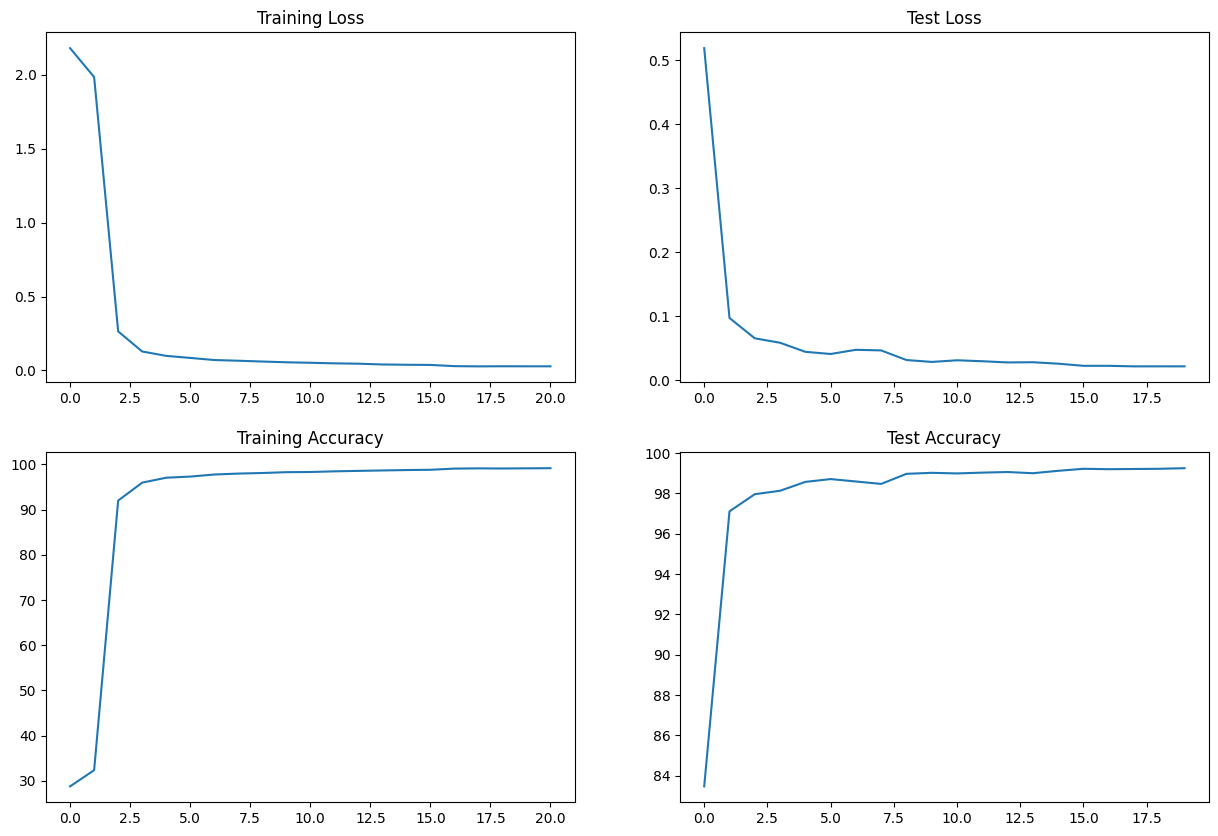

In [19]:
# code block 11

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [20]:
# code block 12

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
